# Tutorial 5 :

**1 - Decision Trees**


**2 - PCA**

**2 - GD+momentum**




## Decision Trees

Decision trees are easily interpreted, require little preprocessing, and are universal function approximators. They can also be used to form random forests.

In this tutorial, you will:
- train and test decision trees using sklearn
- implement decision trees from scratch!

### Prepare the data

We will use the Iris dataset. Start by loading the data and splitting it into train/test sets.

In [ ]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()

# Split into train/test
from sklearn.model_selection import train_test_split

np.random.seed(10)
(iris_train_x, iris_test_x,
 iris_train_y, iris_test_y) = train_test_split(iris.data, iris.target, test_size=50)

print(iris_train_x.shape)
print(iris_test_x.shape)

(100, 4)
(50, 4)


### Decision tree: sklearn implementation

sklearn comes with a decision tree class that we can use to classify Iris data.

Here we will initialize a decision tree model. The `max_depth` argument is the most important hyperparameter. The `criterion` refers to the which loss function we use to determine splits: Gini impurity or entropy. The others are related to optimizations we won't implement.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=3, criterion="entropy")
print(model)

DecisionTreeClassifier(criterion='entropy', max_depth=3)


Train the model:

In [ ]:
model.fit(iris_train_x, iris_train_y)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

sklearn has a nice tool for visualizing the learned decision tree:

[Text(0.375, 0.875, 'X[2] <= 2.45\nentropy = 1.583\nsamples = 100\nvalue = [35, 31, 34]'),
 Text(0.25, 0.625, 'entropy = 0.0\nsamples = 35\nvalue = [35, 0, 0]'),
 Text(0.5, 0.625, 'X[2] <= 4.75\nentropy = 0.998\nsamples = 65\nvalue = [0, 31, 34]'),
 Text(0.25, 0.375, 'X[3] <= 1.6\nentropy = 0.211\nsamples = 30\nvalue = [0, 29, 1]'),
 Text(0.125, 0.125, 'entropy = 0.0\nsamples = 29\nvalue = [0, 29, 0]'),
 Text(0.375, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.75, 0.375, 'X[3] <= 1.75\nentropy = 0.316\nsamples = 35\nvalue = [0, 2, 33]'),
 Text(0.625, 0.125, 'entropy = 0.971\nsamples = 5\nvalue = [0, 2, 3]'),
 Text(0.875, 0.125, 'entropy = 0.0\nsamples = 30\nvalue = [0, 0, 30]')]

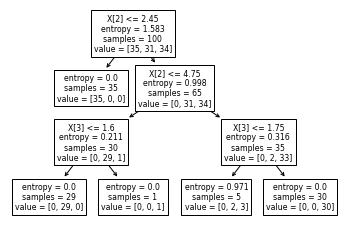

In [ ]:
sklearn.tree.plot_tree(model)

Test the model:

In [ ]:
pred_y = model.predict(iris_test_x)
print(pred_y)

[1 2 0 1 0 1 2 1 0 1 1 2 1 0 0 2 1 0 0 0 2 2 2 0 1 0 1 1 2 2 1 1 2 2 2 0 2
 2 2 2 0 0 1 0 1 0 2 2 2 2]


In [ ]:
Acc = np.sum(iris_test_y == pred_y)/len(iris_test_y)
print('train accuracy = ',Acc*100, '%')

train accuracy =  92.0 %


### Decision tree: our implementation

Now we will implement decision trees ourselves! We will first implement some helper functions.
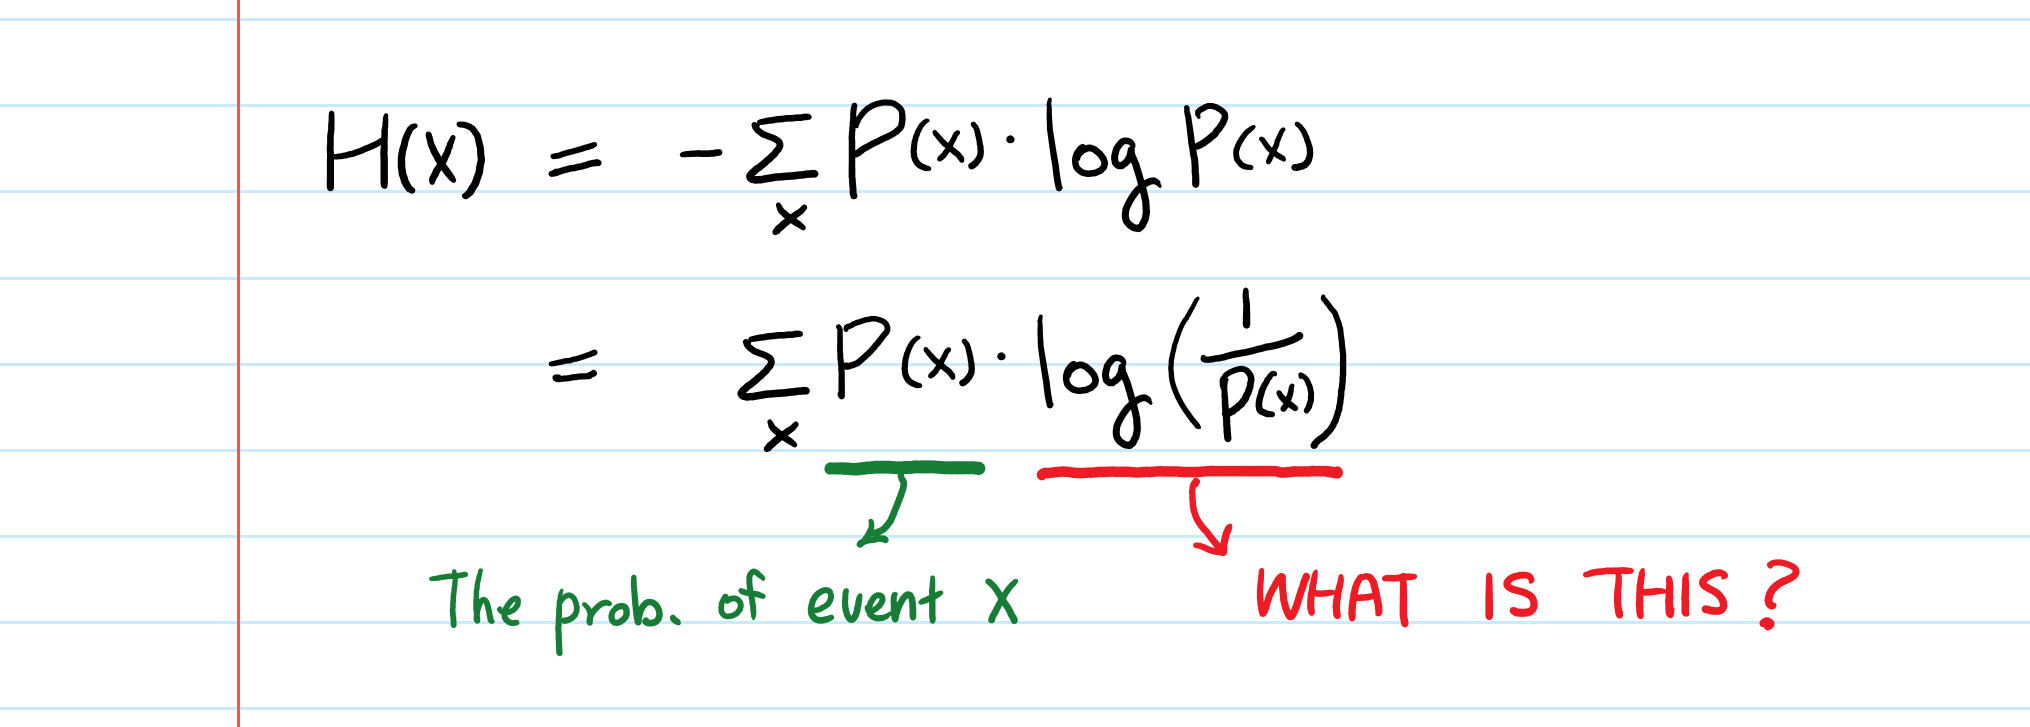

In [ ]:
from collections import Counter

def get_majority_class(labels):
    counts = Counter(labels)
    print(counts)
    return counts.most_common(1)[0][0]

def compute_entropy(labels):
    counts = Counter(labels)
    counts = np.array([counts[key] for key in counts])
    frequencies = counts/counts.sum()
    entropy = -(frequencies * np.log2(frequencies)).sum()
    return entropy

example_labels = np.array([3,1,2,0,2])
print(get_majority_class(example_labels))
print(compute_entropy(example_labels))

Counter({2: 2, 3: 1, 1: 1, 0: 1})
2
1.9219280948873623


Let's write a **Node** class to use in the decision tree. A node in the tree can:
- ask a question,
- find the best question to split a (subset of a) dataset, or
- if it is a leaf node, predict an output.

In [ ]:
class Node():
    def __init__(self):
        self.threshold = None
        self.col = None
        self.is_leaf = None
        self.output_class = None

    def find_best_question(self, x, y):
        best_col = None
        best_val = None
        best_loss = np.inf

        num_cols = x.shape[1]
        valid_cols = np.arange(num_cols)
        print(valid_cols)
        for col in valid_cols:
            ######### finding midpoints ##########
            sorted_indices = x[:, col].argsort()
            sorted_vals = x[sorted_indices, col]
            midpoints = [(sorted_vals[i] + sorted_vals[i+1])/2 for i in range(len(sorted_vals)-1) ]
            # if multiple examples take on the same value, don't take their midpoint
            midpoints = [m for m in midpoints if m not in sorted_vals]
            for val in midpoints:
                right_subset_rows = x[:, col] > val
                left_subset_rows = np.invert(right_subset_rows)
                right_labels = y[right_subset_rows]
                left_labels = y[left_subset_rows]

                right_entropy = compute_entropy(right_labels)
                left_entropy = compute_entropy(left_labels)
                p_right = len(right_labels) / len(y)
                p_left = len(left_labels) / len(y)
                loss = (p_left * left_entropy) + (p_right * right_entropy)
                if right_labels.shape[0] == 0 or left_labels.shape[0] == 0:
                    continue

                if loss < best_loss:
                    best_loss = loss
                    best_col = col
                    best_val = val

        self.col = best_col
        self.threshold = best_val

    def ask_question(self, x):
        if not self.is_leaf:
            return x[:, self.col] > self.threshold
            print()
        else:
            print("Error: leaf nodes cannot ask questions!")
            return False

    def predict(self):
        if self.is_leaf:
            return self.output_class
        else:
            print("Error: non-leaf nodes cannot make a prediction!")
            return None

node=Node()
example_x = np.array([[-2.32,  2.02,  0.53,  0.34],
       [-1.44,  1.36,  0.12, -0.44],
       [-0.28, -0.08,  0.9 , -1.63],
       [-0.09,  0.17, -0.28,  0.44],
       [ 0.8 , -1.65,  1.36,  1.62]])
example_y = np.array([3,1,2,0,2])

# Test find_best_question()
node.find_best_question(example_x, example_y)
print(node.threshold) # should be 0.045
print(node.col) # should be 1

# Test ask_question()
test_x = np.array([[ 1.05, -1.85, -2.24,  1.45],
       [ 1.2 , 2,  1.54, -0.39]])
print(node.ask_question(test_x)) # should be [False False]

[0 1 2 3]
0.045000000000000005
1
[False  True]


Now, using the Node class, we will implement the decision tree. Like scikit-learn's interface, we will have fit() and predict() methods.

In [ ]:
class DecisionTreeClassifier():
    def __init__(self, max_depth=1):
        self.max_depth = max_depth

    def create_node(self, x_subset, y_subset, depth):
        # Recursive function
        node = Node()

        majority_class = get_majority_class(y_subset)
        majority_class_count = (y_subset == majority_class).sum()
        perfectly_classified = majority_class_count == len(y_subset)

        if perfectly_classified or depth == self.max_depth:
            node.output_class = majority_class
            node.is_leaf = True
        else:
            node.find_best_question(x_subset,y_subset)
            node.is_leaf = False
            right_subset_rows = node.ask_question(x_subset)
            left_subset_rows = np.invert(right_subset_rows)
            node.left_child = self.create_node(x_subset[left_subset_rows], y_subset[left_subset_rows],  depth+1)
            node.right_child = self.create_node(x_subset[right_subset_rows], y_subset[right_subset_rows], depth+1)

        return node

    def fit(self, x, y):
        self.root_node = self.create_node(x,y,depth=1)

    def predict(self, x):
        predictions = []

        for i in range(len(x)):
            current_node = self.root_node
            x_i = x[i].reshape(1,-1)
            done_descending_tree = False
            while not done_descending_tree:
                if current_node.is_leaf:
                    predictions.append(current_node.predict())
                    done_descending_tree = True

                else:
                    if current_node.ask_question(x_i):
                        current_node = current_node.right_child
                    else:
                        current_node = current_node.left_child

        return np.array(predictions)


Train a tree to test your implementation. (You can also try comparing with scikit-learn's tree implementation.)

In [ ]:
# import sklearn.tree
# tree = sklearn.tree.DecisionTreeClassifier(max_depth=10)
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(iris_train_x, iris_train_y)
# print(iris_test_y)
# print(tree.predict(iris_test_x))
print("test accuracy= ", (tree.predict(iris_test_x) == iris_test_y).mean() * 100, "%")

Counter({0: 35, 2: 34, 1: 31})
[0 1 2 3]
Counter({0: 35})
Counter({2: 34, 1: 31})
[0 1 2 3]
Counter({1: 29, 2: 1})
Counter({2: 33, 1: 2})
test accuracy=  92.0 %


Train trees of increasing depth on the Iris dataset and plot their performance. What do you notice about the performance as the depth increases?

Counter({0: 35, 2: 34, 1: 31})
Counter({0: 35, 2: 34, 1: 31})
[0 1 2 3]
Counter({0: 35})
Counter({2: 34, 1: 31})
Counter({0: 35, 2: 34, 1: 31})
[0 1 2 3]
Counter({0: 35})
Counter({2: 34, 1: 31})
[0 1 2 3]
Counter({1: 29, 2: 1})
Counter({2: 33, 1: 2})
Counter({0: 35, 2: 34, 1: 31})
[0 1 2 3]
Counter({0: 35})
Counter({2: 34, 1: 31})
[0 1 2 3]
Counter({1: 29, 2: 1})
[0 1 2 3]
Counter({1: 29})
Counter({2: 1})
Counter({2: 33, 1: 2})
[0 1 2 3]
Counter({2: 3, 1: 2})
Counter({2: 30})
Counter({0: 35, 2: 34, 1: 31})
[0 1 2 3]
Counter({0: 35})
Counter({2: 34, 1: 31})
[0 1 2 3]
Counter({1: 29, 2: 1})
[0 1 2 3]
Counter({1: 29})
Counter({2: 1})
Counter({2: 33, 1: 2})
[0 1 2 3]
Counter({2: 3, 1: 2})
[0 1 2 3]
Counter({2: 3})
Counter({1: 2})
Counter({2: 30})
Counter({0: 35, 2: 34, 1: 31})
[0 1 2 3]
Counter({0: 35})
Counter({2: 34, 1: 31})
[0 1 2 3]
Counter({1: 29, 2: 1})
[0 1 2 3]
Counter({1: 29})
Counter({2: 1})
Counter({2: 33, 1: 2})
[0 1 2 3]
Counter({2: 3, 1: 2})
[0 1 2 3]
Counter({2: 3})
Counter(

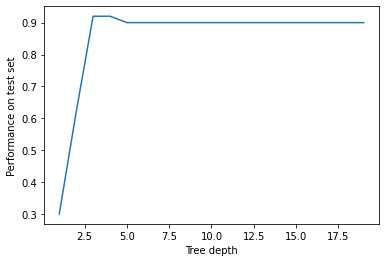

In [ ]:
depths = []
accuracies = []
import sklearn.tree
for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth)
    # model = sklearn.tree.DecisionTreeClassifier(max_depth=depth)
    model.fit(iris_train_x, iris_train_y)
    accuracy = (model.predict(iris_test_x) == iris_test_y).mean()
    accuracies.append(accuracy)
    depths.append(depth)

print("Best performance: ", max(accuracies))
plt.xlabel('Tree depth')
plt.ylabel('Performance on test set')
plt.plot(depths, accuracies)

## PCA

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

Up until now, we have been looking in depth at supervised learning estimators: those estimators that predict labels based on labeled training data.
Here we begin looking at several unsupervised estimators, which can highlight interesting aspects of the data without reference to any known labels.

In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analysis (PCA).
PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.


We begin with the standard imports:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # a library for making statistical graphics in Python

### Introducing Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data.
Its behavior is easiest to visualize by looking at a two-dimensional dataset.
Consider the following 200 points:

(200, 2)


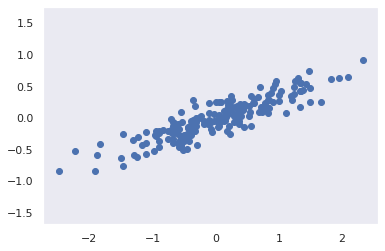

In [ ]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
print(X.shape)
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');
plt.grid()

By eye, it is clear that there is a nearly linear relationship between the x and y variables.

Rather than attempting to *predict* the y values from the x values, the unsupervised learning problem attempts to learn about the *relationship* between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.
Using Scikit-Learn's ``PCA`` estimator, we can compute this as follows:

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [ ]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [ ]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

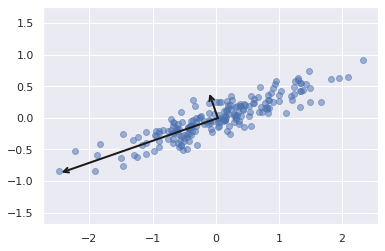

In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = plt.gca() #Get the current Axes instance on the current figure matching the given keyword args, or create one
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0,color='k')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector *3 *np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the *principal axes* of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis.
The projection of each data point onto the principal axes are the "principal components" of the data.

If we plot these principal components beside the original data, we see the plots shown here:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.09-PCA-rotation.png?raw=1)


This transformation from data axes to principal axes is an *affine transformation*, which basically means it is composed of a translation, rotation, and uniform scaling.

While this algorithm to find principal components may seem like just a mathematical curiosity, it turns out to have very far-reaching applications in the world of machine learning and data exploration.

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.


Here is an example of using PCA as a dimensionality reduction transform:

In [ ]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

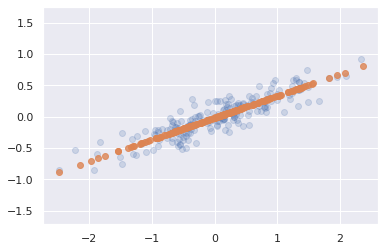

In [ ]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.
This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.



##GD+momentum

This section is taken from https://www.cs.toronto.edu/~mren/teach/csc411_19s/#tutorials.)

In [ ]:
import autograd.numpy as np
import autograd
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)
import time

This tutorial explores _optimization for machine learning_.

We will implement a function and then use gradient-based optimization to find it's minimum value.
For ease of visualization we will consider scalar functions of 2-d vectors.
In other words $f: \mathbb{R}^2 \rightarrow \mathbb{R}$

One example of such a function is the simple quadratic $$f(x) = \frac{1}{2} x^T x = \frac{1}{2}(x_0^2 + x_1^2)$$ where $x_i$ represents the $i$-th entry of the vector $x$.

Let's implement this in code and print $f(x)$ for a few random $x$

In [ ]:
def f(x):
    return 0.5*np.dot(x.T, x)

for _ in range(5):
    x = np.random.randn(2)  # random 2-d vector
    print('x={}, f(x)={:.3f}'.format(x, f(x)))

x=[0.679 0.41 ], f(x)=0.314
x=[-0.49 -0.01], f(x)=0.120
x=[-1.32   0.426], f(x)=0.962
x=[ 0.466 -0.403], f(x)=0.190
x=[-0.001 -0.725], f(x)=0.263


This simple function has minimum value $f(x^*)=0$ given by $x^* = [0, 0]^T$.

Let's look at the more general quadratic
$$f(x) = \frac{1}{2}x^T A x$$
where $A \in \mathbb{R}^{2 \times 2}$ is a positive semi-definite matrix.

Notice that we get the previous function when we set $A$ to the identity matrix $I$.

We can think of this function as a quadratic bowl whose curvature is specified by the value of $A$.
This is evident in the isocontour plots of $f(x)$ for various $A$.
Let's take a look.


In [ ]:
# helper function yielding a random positive semi-definite matrix
def random_psd_matrix(seed=None):
    """return random positive semi-definite matrix with norm one"""
    np.random.seed(seed)
    A = np.random.randn(2,2)
    A = np.dot(A.T,A)
    A = np.dot(A.T,A)
    A = A / np.linalg.norm(A)
    return A

# define forward function
def f(x, a):
    """f(x) = x^T A x"""
    y = 0.5*np.dot(x.T, np.dot(a, x))
    return y

# helper function for isocontour plotting
def plot_isocontours(one_d_grid, g):
    """
    first makes a 2d grid from the 1d grid
    then plots isocontours using the function g
    """
    X,Y = np.meshgrid(one_d_grid, one_d_grid)  # build 2d grid
    Z = np.zeros_like(X)
    # numpy bonus exercise: can you think of a way to vectorize the following for-loop?
    for i in range(len(X)):
        for j in range(len(X.T)):
            Z[i, j] = g(np.array((X[i, j], Y[i, j])))  # compute function values
    fig, ax = plt.subplots()
    ax.contour(X, Y, Z, 100)
    return fig, ax

A=[[1. 1.]
 [1. 1.]]


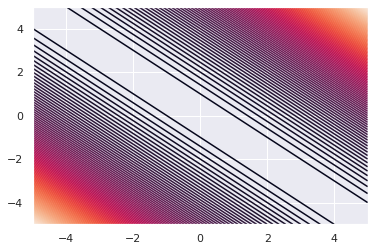

A=[[0.449 0.454]
 [0.454 0.622]]


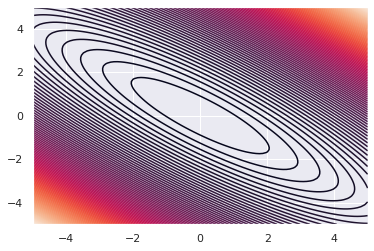

A=[[0.926 0.262]
 [0.262 0.074]]


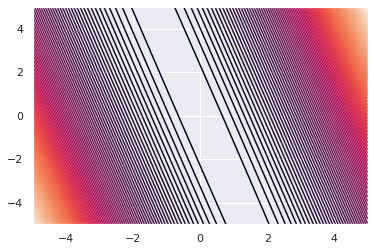

In [ ]:
for A in [np.ones((2, 2)), random_psd_matrix(), random_psd_matrix()]:  # try a few values of A
    print('A={}'.format(A))
    fig, ax = plot_isocontours(np.linspace(-5, 5, 100), lambda x: f(x, A))
    plt.show()
    time.sleep(1.0)

Now let's learn how to find the minimal value of $f(x)$.
We need to solve the following optimization problem:
$$x^* = \underset{x}{\arg \min} \quad \frac{1}{2}x^T A x = \underset{x}{\arg \min} \quad f(x)$$


Modern machine learning optimization tools rely on gradients.
Consider gradient descent, which initializes $x_0$ at random then follows the update rule
$$ x_{t+1} \leftarrow x_t - \eta \nabla_x f(x_t)$$
where $\eta$ represents the learning rate.

So we need to compute $\nabla_x f(x)$. For simple functions like ours, we can compute this analytically:
$$\nabla_x f(x) = \nabla_x \left( \frac{1}{2}x^T A x \right) = A x$$

In other words, to compute the gradient of $f(x)$ at a particular $x=x'$, we matrix multiply $A$ with $x'$

But deriving the analytic gradients by hand becomes painful as $f$ gets more complicated. Instead we can use automatic differentation packages like [`autograd`](https://github.com/HIPS/autograd) to do this hard work for us. All we need to do is specify the forward function.

Let's take a look at the two approaches:

In [ ]:
# define df/dx via automatic differentiation
df_dx = autograd.grad(f, 0)
# ^ the second argument of grad specifies which argument we're differentiating with respect to

# define df/dx analytically
def analytic_gradient(x, A):
    return np.dot(A, x)

for A in [np.zeros((2, 2)), np.eye(2), random_psd_matrix()]:  # try a few values of A
    x = np.random.randn(2)  # generate x randomly
    print('')
    print('x={}\nA={}\nf(x,A)={:.3f}\ndf/dx={}'.format(x, A, f(x,A), df_dx(x,A)))
    print('analytic_gradient:',analytic_gradient(x, A))
    assert np.isclose(np.sum((df_dx(x, A) - analytic_gradient(x, A)))**2, 0.), 'bad maths'  # unit test



x=[0.511 0.362]
A=[[0. 0.]
 [0. 0.]]
f(x,A)=0.000
df/dx=[0. 0.]
analytic_gradient: [0. 0.]

x=[-1.507 -0.026]
A=[[1. 0.]
 [0. 1.]]
f(x,A)=1.136
df/dx=[-1.507 -0.026]
analytic_gradient: [-1.507 -0.026]

x=[ 0.663 -0.97 ]
A=[[ 0.176 -0.379]
 [-0.379  0.826]]
f(x,A)=0.671
df/dx=[ 0.484 -1.052]
analytic_gradient: [ 0.484 -1.052]


Now that we know how to compute $\nabla_x f(x)$ using `autograd`, let's implement gradient descent.

To make the implementation of GD crystal clear, let's break this update expression from above into two lines:
$$ \delta_{t+1} \leftarrow - \eta \nabla_x f(x_t)$$
$$ x_{t+1} \leftarrow x_t + \delta_{t+1}$$

This yields the following `autograd` implementation:

final value f(x)=0.126 at x=[-0.117 -0.55 ]


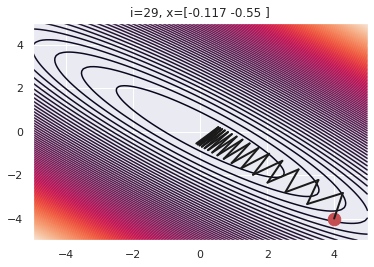

In [ ]:
A = random_psd_matrix(0)  # argument specifies the random seed
fig, ax = plot_isocontours(np.linspace(-5, 5, 100), lambda x: f(x, A))  # plot function isocontours

# hyperparameters
LEARNING_RATE = 2
INITIAL_VAL = np.array([4., -4.])  # initialize

x = np.copy(INITIAL_VAL)
ax.plot(*x, marker='.', color='r', ms=25)  # plot initial values



from IPython import display

for i in range(30):

    x_old = np.copy(x)
    delta = -LEARNING_RATE*df_dx(x, A)  # compute gradient times learning rate
    x += delta  # update params

    # plot
    ax.plot([x_old[0], x[0]], [x_old[1], x[1]], linestyle='-', color='k',lw=2)  # plot a line connecting old and new param values
    fig.canvas.draw()
    ax.set_title('i={}, x={}'.format(i, x))
    display.display(fig)
    display.clear_output(wait=True)

print('final value f(x)={:.3f} at x={}'.format(f(x, A), x))


Cool! Now let's try gradient descent _with momentum_. The hyperparameters are the learning rate $\eta$ and momentum value $\alpha \in [0, 1)$.

We randomly initialize $x_0$ like before. We initialize $\delta_0$ to the zero vector. Then proceed with updates as:
$$\delta_{t+1} \leftarrow -\eta \nabla_x f(x) + \alpha \delta_t$$
$$x_{t+1} \leftarrow x_t + \delta_{t+1}$$

This yields the following `autograd` implementation:

final value f(x)=0.004 at x=[ 0.323 -0.276]


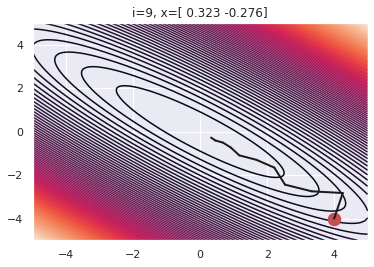

In [ ]:
fig, ax = plot_isocontours(np.linspace(-5, 5, 100), lambda x: f(x, A))  # plot function isocontours

# initialize
x = np.copy(INITIAL_VAL)
delta = np.zeros(2)
ax.plot(*x, marker='.', color='r', ms=25)  # plot initial values

# hyperparameters
LEARNING_RATE = 2.0 #.1
ALPHA = 0.5

from IPython import display

for i in range(10):
#    input("Press Enter to continue...")  # optional; Enter key triggers next update
#    time.sleep(0.5)  # optional; slow down animation if the flickering is distracting

    x_old = np.copy(x)
    g = df_dx(x, A)  # compute standard gradient
    delta = -LEARNING_RATE*g + ALPHA*delta  # update momentum term
    x += delta  # update params

    # plot
    ax.plot([x_old[0], x[0]], [x_old[1], x[1]],'-k',lw=2)  # plot a line connecting old and new param values
    fig.canvas.draw()
    ax.set_title('i={}, x={}'.format(i, x))
    display.display(fig)
    display.clear_output(wait=True)

print('final value f(x)={:.3f} at x={}'.format(f(x, A), x))
